## 1. Data Preparation


In [1]:
import torch
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
from datasets import Dataset

In [ ]:
# Step 1: 读取上传的文本文件
file_path = "tinyshakespeare.txt"
with open(file_path, 'r', encoding='utf-8') as f:
    text = f.read()

# Step 2: 将文本按行分割成句子或段落
data = text.strip().split('\n')
data = [line for line in data if len(line.strip()) > 0]  # 清除空行

# Step 3: 转换为 HuggingFace 数据集对象
dataset = Dataset.from_dict({'text': data})

# Step 4: 初始化 BERT 分词器
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("local_bert_base_uncased")

# Step 5: 编码函数（不重命名 input_ids！）
def preprocess_function(examples):
    return tokenizer(
        examples['text'],
        truncation=True,
        padding='max_length',
        max_length=64
    )

# Step 6: 批量处理数据
tokenized_datasets = dataset.map(preprocess_function, batched=True)

# Step 7: 拆分训练集和测试集
split_dataset = tokenized_datasets.train_test_split(test_size=0.2)
train_dataset = split_dataset["train"]
test_dataset = split_dataset["test"]

# Step 8: 设置 PyTorch 数据格式（保留 input_ids！）
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "token_type_ids"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "token_type_ids"])

# Step 9: 打印示例验证
print(f"Train Dataset Sample: {train_dataset[0]}")
print(f"Test Dataset Sample: {test_dataset[0]}")



Map:   0%|          | 0/32777 [00:00<?, ? examples/s]

Train Dataset Sample: {'input_ids': tensor([  101,  2038,  1996,  3653,  6916,  4355,  2293,  1011,  2774,  2005,
        29229,  1025,  2061,  2302,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [3]:
import torch.nn as nn

class PPCMaskedLanguageModel(nn.Module):
    def __init__(self, encoder, vocab_size, d_model):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.encoder = encoder
        self.lm_head = nn.Linear(d_model, vocab_size)

    def forward(self, input_ids, attention_mask):
        # input_ids: (batch_size, seq_len)
        embedded = self.embedding(input_ids).transpose(0, 1)  # (seq_len, batch_size, d_model)
        encoded = self.encoder(embedded, src_key_padding_mask=~attention_mask.bool())  # (seq_len, batch, d_model)
        encoded = encoded.transpose(0, 1)  # (batch_size, seq_len, d_model)
        logits = self.lm_head(encoded)     # (batch_size, seq_len, vocab_size)
        return logits


In [4]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15
)


In [5]:
from torch.utils.data import DataLoader

batch_size = 32

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, collate_fn=data_collator)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=data_collator)


In [6]:
from PPC_transformer_encoder import PPCTransformerEncoderLayer, PPCTransformerEncoder
import torch

d_model = 256
nhead = 2
dim_feedforward = 512
dropout = 0.1
num_layers = 3
r_max_scale = 0.3

vocab_size = tokenizer.vocab_size

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder_layer = PPCTransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout, r_max_scale=  r_max_scale)
encoder = PPCTransformerEncoder(encoder_layer, num_layers=num_layers)

model = PPCMaskedLanguageModel(encoder, vocab_size=vocab_size, d_model=d_model).to(device)

In [7]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm
import torch.nn as nn

# 优化器
optimizer = AdamW(model.parameters(), lr=5e-4)

# 损失函数
criterion = nn.CrossEntropyLoss(ignore_index=-100)

# 超参数
num_epochs = 30
total_steps = len(train_dataloader) * num_epochs
warmup_steps = int(0.1 * total_steps)  # warmup 10% 步数

# 调度器
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)


In [8]:
from torch.utils.tensorboard import SummaryWriter
from PPC_linear import unorthogonality_decay_all
import gc

writer = SummaryWriter(log_dir='./tf_dir/exp1')

global_step = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}", leave=True)

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(logits.view(-1, vocab_size), labels.view(-1))
        # 应用正则化
        unorthogonality_decay_all(model, decay_rate=0.01)
        loss.backward()
        optimizer.step()
        scheduler.step()

        loss_val = loss.item()
        total_loss += loss_val
        writer.add_scalar('Loss/train_batch', loss_val, global_step)
        writer.add_scalar('LearningRate/train_batch', optimizer.param_groups[0]['lr'], global_step)
        progress_bar.set_postfix(loss=loss_val)
        global_step += 1

    avg_loss = total_loss / len(train_dataloader)
    print(f"\nEpoch {epoch+1} Average Loss: {avg_loss:.4f}")
    writer.add_scalar('Loss/train_epoch', avg_loss, epoch)

    # === 每个 epoch 后进行一次 evaluation ===
    model.eval()
    total = 0
    correct = 0

    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids, attention_mask)
            predictions = torch.argmax(logits, dim=-1)

            mask = labels != -100
            correct += (predictions[mask] == labels[mask]).sum().item()
            total += mask.sum().item()

    accuracy = correct / total
    print(f"Epoch {epoch+1} Test Accuracy: {accuracy * 100:.2f}%")
    writer.add_scalar('Accuracy/test', accuracy, epoch)

    # 显存和内存清理
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    gc.collect()

writer.close()


Epoch 1: 100%|██████████| 820/820 [00:17<00:00, 47.02it/s, loss=6.99]



Epoch 1 Average Loss: 7.7450
Epoch 1 Test Accuracy: 8.67%


Epoch 2: 100%|██████████| 820/820 [00:18<00:00, 44.13it/s, loss=5.75]



Epoch 2 Average Loss: 6.3249
Epoch 2 Test Accuracy: 11.86%


Epoch 3: 100%|██████████| 820/820 [00:17<00:00, 47.27it/s, loss=5.09]



Epoch 3 Average Loss: 6.0103
Epoch 3 Test Accuracy: 14.11%


Epoch 4: 100%|██████████| 820/820 [00:17<00:00, 47.46it/s, loss=4.95]



Epoch 4 Average Loss: 5.7631
Epoch 4 Test Accuracy: 17.46%


Epoch 5: 100%|██████████| 820/820 [00:15<00:00, 54.24it/s, loss=5.34]



Epoch 5 Average Loss: 5.5924
Epoch 5 Test Accuracy: 19.00%


Epoch 6: 100%|██████████| 820/820 [00:14<00:00, 54.98it/s, loss=5.99]



Epoch 6 Average Loss: 5.4861
Epoch 6 Test Accuracy: 19.43%


Epoch 7: 100%|██████████| 820/820 [00:17<00:00, 46.21it/s, loss=5.94]



Epoch 7 Average Loss: 5.3726
Epoch 7 Test Accuracy: 19.54%


Epoch 8: 100%|██████████| 820/820 [00:20<00:00, 40.97it/s, loss=5.25]



Epoch 8 Average Loss: 5.3131
Epoch 8 Test Accuracy: 20.40%


Epoch 9: 100%|██████████| 820/820 [00:17<00:00, 46.18it/s, loss=4.84]



Epoch 9 Average Loss: 5.2395
Epoch 9 Test Accuracy: 20.84%


Epoch 10: 100%|██████████| 820/820 [00:15<00:00, 54.66it/s, loss=5.84]



Epoch 10 Average Loss: 5.1961
Epoch 10 Test Accuracy: 21.42%


Epoch 11: 100%|██████████| 820/820 [00:15<00:00, 54.03it/s, loss=4.96]



Epoch 11 Average Loss: 5.1465
Epoch 11 Test Accuracy: 21.19%


Epoch 12: 100%|██████████| 820/820 [00:20<00:00, 40.65it/s, loss=4.88]



Epoch 12 Average Loss: 5.1186
Epoch 12 Test Accuracy: 21.73%


Epoch 13: 100%|██████████| 820/820 [00:18<00:00, 45.43it/s, loss=5.72]



Epoch 13 Average Loss: 5.0350
Epoch 13 Test Accuracy: 21.19%


Epoch 14: 100%|██████████| 820/820 [00:15<00:00, 53.78it/s, loss=4.72]



Epoch 14 Average Loss: 4.9888
Epoch 14 Test Accuracy: 21.42%


Epoch 15: 100%|██████████| 820/820 [00:15<00:00, 54.46it/s, loss=5.32]



Epoch 15 Average Loss: 4.9538
Epoch 15 Test Accuracy: 21.97%


Epoch 16: 100%|██████████| 820/820 [00:15<00:00, 53.31it/s, loss=4.36]



Epoch 16 Average Loss: 4.9546
Epoch 16 Test Accuracy: 21.38%


Epoch 17: 100%|██████████| 820/820 [00:15<00:00, 53.98it/s, loss=5.53]



Epoch 17 Average Loss: 4.8864
Epoch 17 Test Accuracy: 21.86%


Epoch 18: 100%|██████████| 820/820 [00:15<00:00, 54.03it/s, loss=3.72]



Epoch 18 Average Loss: 4.8525
Epoch 18 Test Accuracy: 21.65%


Epoch 19: 100%|██████████| 820/820 [00:15<00:00, 54.44it/s, loss=5.82]



Epoch 19 Average Loss: 4.8205
Epoch 19 Test Accuracy: 22.04%


Epoch 20: 100%|██████████| 820/820 [00:15<00:00, 53.98it/s, loss=5.04]



Epoch 20 Average Loss: 4.7932
Epoch 20 Test Accuracy: 22.95%


Epoch 21: 100%|██████████| 820/820 [00:15<00:00, 53.97it/s, loss=4.8] 



Epoch 21 Average Loss: 4.7218
Epoch 21 Test Accuracy: 22.49%


Epoch 22: 100%|██████████| 820/820 [00:16<00:00, 50.66it/s, loss=5.2] 



Epoch 22 Average Loss: 4.7241
Epoch 22 Test Accuracy: 22.27%


Epoch 23: 100%|██████████| 820/820 [00:15<00:00, 51.81it/s, loss=4.86]



Epoch 23 Average Loss: 4.6700
Epoch 23 Test Accuracy: 22.17%


Epoch 24: 100%|██████████| 820/820 [00:15<00:00, 52.78it/s, loss=4.98]



Epoch 24 Average Loss: 4.6602
Epoch 24 Test Accuracy: 23.08%


Epoch 25: 100%|██████████| 820/820 [00:17<00:00, 48.12it/s, loss=5.26]



Epoch 25 Average Loss: 4.6231
Epoch 25 Test Accuracy: 23.47%


Epoch 26: 100%|██████████| 820/820 [00:19<00:00, 43.12it/s, loss=4.73]



Epoch 26 Average Loss: 4.6095
Epoch 26 Test Accuracy: 22.85%


Epoch 27: 100%|██████████| 820/820 [00:17<00:00, 47.93it/s, loss=4.88]



Epoch 27 Average Loss: 4.5655
Epoch 27 Test Accuracy: 22.96%


Epoch 28: 100%|██████████| 820/820 [00:15<00:00, 53.60it/s, loss=4.06]



Epoch 28 Average Loss: 4.5655
Epoch 28 Test Accuracy: 22.75%


Epoch 29: 100%|██████████| 820/820 [00:15<00:00, 53.91it/s, loss=4.1] 



Epoch 29 Average Loss: 4.5571
Epoch 29 Test Accuracy: 22.46%


Epoch 30: 100%|██████████| 820/820 [00:15<00:00, 53.03it/s, loss=5.52]



Epoch 30 Average Loss: 4.5312
Epoch 30 Test Accuracy: 22.81%


In [9]:
# 统计参数总数
total_params = sum(p.numel() for p in model.parameters())

# 如果只想统计可训练的参数（排除冻结参数）
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")


Total parameters: 16799490
Trainable parameters: 16799490


In [ ]:
torch.save(model.state_dict(), 'PPC_Bert_weights.pth')

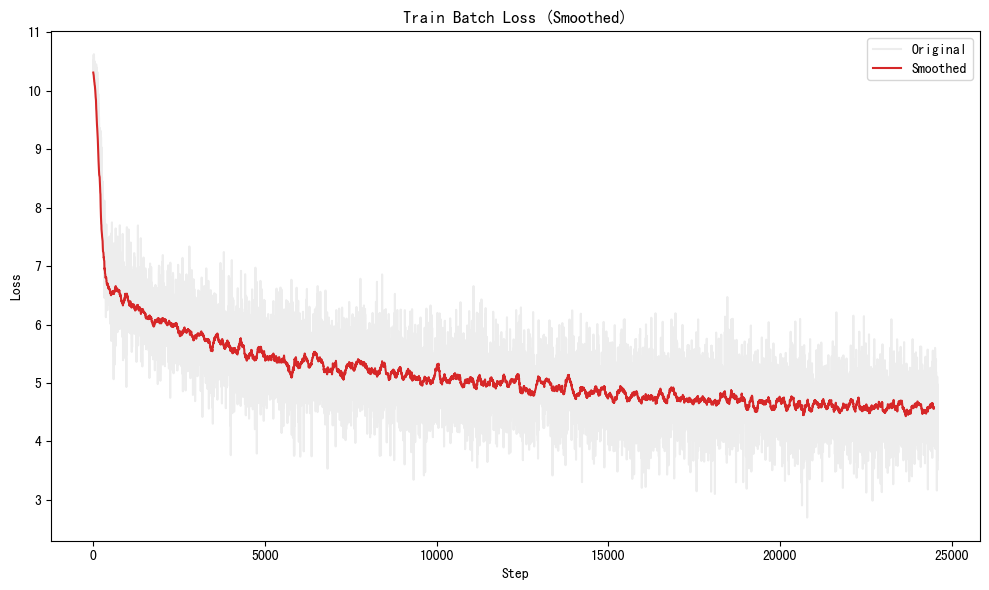

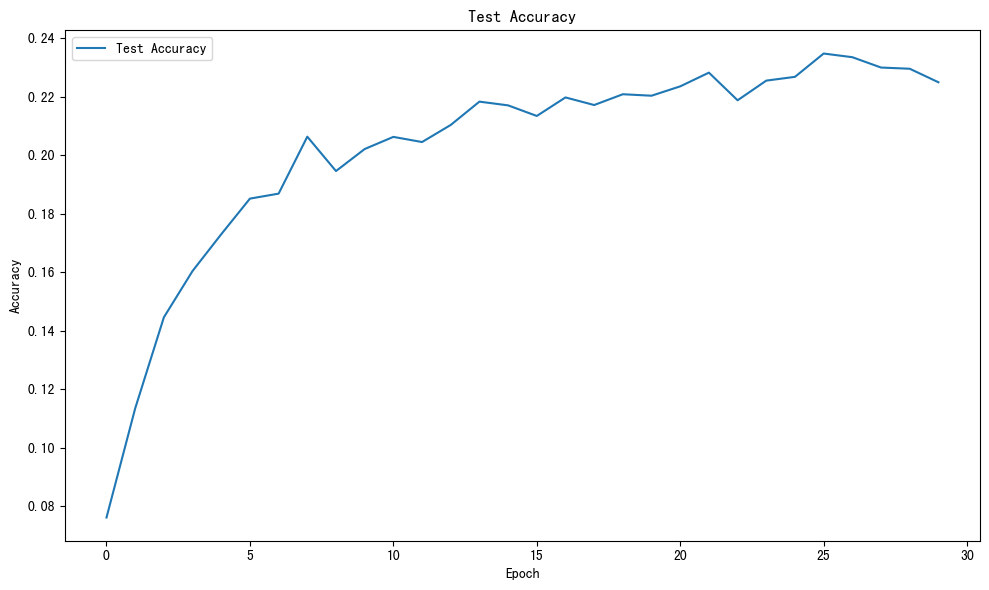

In [19]:
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator
import numpy as np

# 设置 TensorBoard 日志路径
log_dir = './tf_dir/exp1'

# 获取 event 文件
event_files = [os.path.join(log_dir, f) for f in os.listdir(log_dir) if 'tfevents' in f]
assert event_files, "未找到 TensorBoard 的日志文件"

# 加载日志
ea = event_accumulator.EventAccumulator(event_files[0])
ea.Reload()

# 选择要可视化的标签
tags = ['Loss/train_batch', 'Accuracy/test']
data = {}
for tag in tags:
    if tag in ea.Tags()['scalars']:
        events = ea.Scalars(tag)
        steps = [e.step for e in events]
        values = [e.value for e in events]
        data[tag] = (np.array(steps), np.array(values))
    else:
        print(f"⚠️ 警告：未找到标签 {tag}")

# === 平滑函数：滑动平均 ===
def smooth_curve(values, window_size=20):
    if len(values) < window_size:
        return values
    return np.convolve(values, np.ones(window_size)/window_size, mode='valid')

# === 单独画 Loss/train_batch ===
if 'Loss/train_batch' in data:
    steps, values = data['Loss/train_batch']
    smoothed_values = smooth_curve(values, window_size=50)
    smoothed_steps = steps[:len(smoothed_values)]

    plt.figure(figsize=(10, 6))
    plt.plot(steps, values, color='lightgray', label='Original', alpha=0.4)
    plt.plot(smoothed_steps, smoothed_values, color='tab:red', label='Smoothed')
    plt.title('Train Batch Loss (Smoothed)')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

# === 单独画 Accuracy/test ===
if 'Accuracy/test' in data:
    steps, values = data['Accuracy/test']

    plt.figure(figsize=(10, 6))
    plt.plot(steps, values, label='Test Accuracy', color='tab:blue')
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

